<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/statistical_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Testing

This notebook implements statistical tests to model validation. The idea is to analyze whether the signal in the error is random, so a model has extracted all the information regarding the dynamics of the system. The tests are:

\begin{equation}
  \begin{cases}
    \varphi_{\xi\xi}(\tau) = \delta(\tau), & \\
    \varphi_{u\xi}(\tau) = 0, & \forall \tau, \\
    \varphi_{\xi(\xi u)}(\tau) = 0, & \tau \geq 0, \\
    \varphi_{(u^2)'\xi}(\tau) = 0, & \forall \tau, \\
    \varphi_{(u^2)'\xi^2}(\tau) = 0, & \forall \tau,
  \end{cases}
\end{equation}

For demonstration purposes, we use random signals for $e,u$ to visualize the test results. To apply this script for your specific needs, replace the random signals with your **OSA error** and **excitation signals** to train your model.



## Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- crossco function, based on https://www.mathworks.com/matlabcentral/fileexchange/87-nnsysid
def crossco(v, w, maxlag=25):
    """
    Calculate cross-correlation coefficients.

    Args:
        v (np.array): First signal vector.
        w (np.array): Second signal vector.
        maxlag (int): Maximum lag to calculate correlation.

    Returns:
        np.array: Array of correlation coefficients.
    """
    if v.shape != w.shape:
        raise ValueError("v and w must have the same length")

    # Extract mean and make sure the vectors are column vectors
    v = v.flatten() - np.mean(v)
    w = w.flatten() - np.mean(w)

    maxlag = min(maxlag, len(v) - 1)

    # Calculate normalization coefficient
    normcoef = np.sqrt(np.sum(v**2) * np.sum(w**2))

    # Calculate correlation for positive lags (v lagged w.r.t w)
    coefs_pos = np.zeros(maxlag + 1)
    for k in range(maxlag + 1):
        coefs_pos[k] = np.sum(v[0:len(v)-k] * w[k:len(w)]) / normcoef

    # Calculate correlation for negative lags (w lagged w.r.t v)
    coefs_neg = np.zeros(maxlag)
    for k in range(1, maxlag + 1):
        coefs_neg[k-1] = np.sum(w[0:len(w)-k] * v[k:len(v)]) / normcoef

    # Combine positive and negative lags, with negative lags first (flipped)
    coefs = np.concatenate((np.flipud(coefs_neg), coefs_pos))
    return coefs

# --- Plot statistical model validation tests ---
def plot_xcorrel(e, u, maxlag = 25):
    """
    Plots correlation based tests similar to MATLAB's plot_xcorrel.

    Args:
        e (np.array): Vector of residuals (error).
        u (np.array): Vector of inputs.
    """
    N = len(u)

    # --- Plots ---
    conf_factor = 1.96 / np.sqrt(N)
    lag_vec = np.arange(-maxlag, maxlag + 1)
    conf = np.array([np.ones(len(lag_vec)) * conf_factor, np.ones(len(lag_vec)) * -conf_factor])

    plt.figure(figsize=(8, 10))

    # Subplot 1: Auto-correlation of residuals (phi_xi_xi)
    plt.subplot(5, 1, 1)
    EE = crossco(e, e, maxlag)
    plt.plot(lag_vec, EE, 'k')
    plt.plot(lag_vec, conf[0], 'k:', label='Confidence Limits')
    plt.plot(lag_vec, conf[1], 'k:')
    plt.xlim([-maxlag, maxlag])
    plt.ylim([-1, 1])
    plt.ylabel(r'$\phi_{\xi\xi}(\tau)$', fontsize=14)
    plt.title('Correlation Based Model Validation Tests')
    plt.grid(True)

    # Subplot 2: Cross-correlation between input and residuals (phi_u_xi)
    plt.subplot(5, 1, 2)
    UE = crossco(u, e, maxlag)
    plt.plot(lag_vec, UE, 'k')
    plt.plot(lag_vec, conf[0], 'k:')
    plt.plot(lag_vec, conf[1], 'k:')
    plt.xlim([-maxlag, maxlag])
    plt.ylim([-1, 1])
    plt.ylabel(r'$\phi_{u\xi}(\tau)$', fontsize=14)
    plt.grid(True)

    # Subplot 3: Cross-correlation between lagged residual and product of lagged residual and input (phi_xi_xi_u)
    plt.subplot(5, 1, 3)
    EEU = crossco(e[0:-1], e[1:] * u[1:], maxlag)
    lag_vec_positive = np.arange(0, maxlag + 1)
    conf_positive = np.array([np.ones(len(lag_vec_positive)) * conf_factor, np.ones(len(lag_vec_positive)) * -conf_factor])

    EEU_positive_lags = EEU[maxlag:] # From lag 0 to maxlag

    plt.plot(lag_vec_positive, EEU_positive_lags, 'k')
    plt.plot(lag_vec_positive, conf_positive[0], 'k:')
    plt.plot(lag_vec_positive, conf_positive[1], 'k:')
    plt.xlim([0, maxlag])
    plt.ylim([-1, 1])
    plt.ylabel(r'$\phi_{\xi(\xi u)}(\tau)$', fontsize=14)
    plt.grid(True)

    # Subplot 4: Cross-correlation between squared input (mean-removed) and residuals (phi_u^2_prime_xi)
    plt.subplot(5, 1, 4)
    U2E = crossco(u**2 - np.mean(u**2), e, maxlag)
    plt.plot(lag_vec, U2E, 'k')
    plt.plot(lag_vec, conf[0], 'k:')
    plt.plot(lag_vec, conf[1], 'k:')
    plt.xlim([-maxlag, maxlag])
    plt.ylim([-1, 1])
    plt.ylabel(r'$\phi_{(u^2)\prime \xi}(\tau)$', fontsize=14)
    plt.grid(True)

    # Subplot 5: Cross-correlation between squared input (mean-removed) and squared residuals (phi_u^2_prime_xi^2)
    plt.subplot(5, 1, 5)
    U2E2 = crossco(u**2 - np.mean(u**2), e**2, maxlag)
    plt.plot(lag_vec, U2E2, 'k')
    plt.plot(lag_vec, conf[0], 'k:')
    plt.plot(lag_vec, conf[1], 'k:')
    plt.xlim([-maxlag, maxlag])
    plt.ylim([-1, 1])
    plt.ylabel(r'$\phi_{(u^2)\prime \xi^2}(\tau)$', fontsize=14)
    plt.xlabel(r'$\tau$', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Test with random data

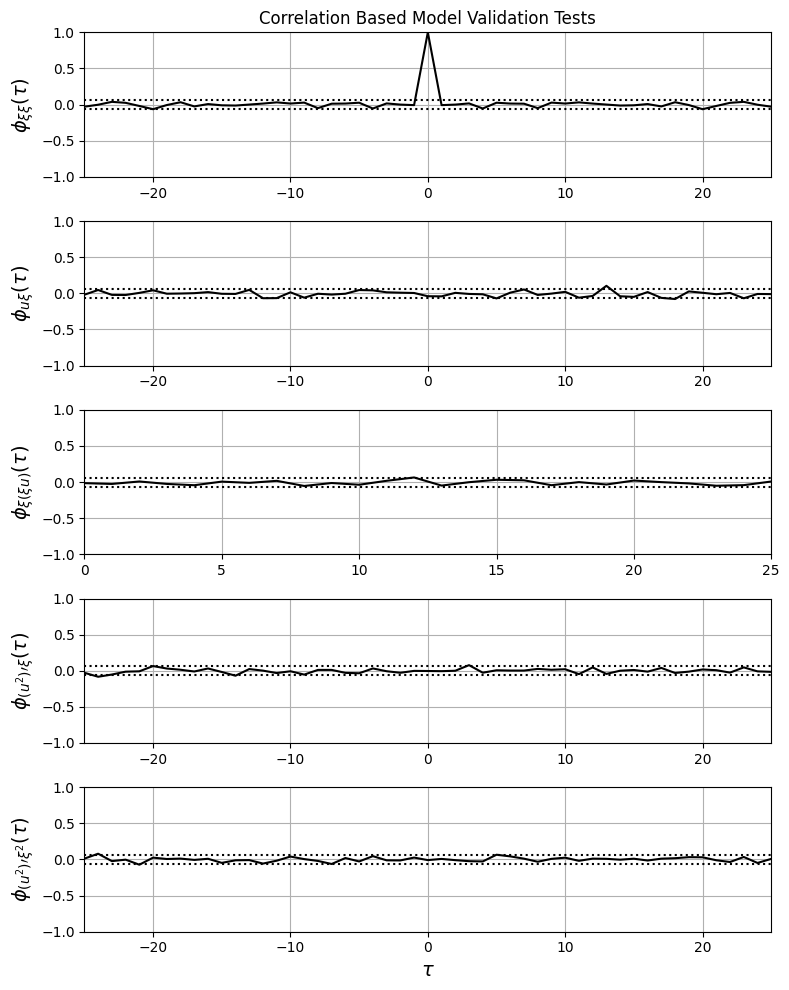

In [ ]:
# --- 1. Create artificial signals (e and u) ---
np.random.seed(42) # for reproducibility
N = 1000 # length of signals

# White random noise for error (e)
e = np.random.randn(N)

# White random noise for input (u)
u = np.random.randn(N)

# --- Run the plot_xcorrel function with our artificial signals ---
plot_xcorrel(e, u)
